In [1]:
import pandas as pd
import pickle
import numpy as np
import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns",50)
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'


C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Training Set

In [2]:
# Load the training set
df = pd.read_csv('training_data/utah_training_set.csv').drop(columns=['fid','index','join_key'],errors='ignore')
df = df.dropna(how='any',axis=0)

In [4]:
ohe_fields=['one_way','surface_type']
df_ohe = pd.get_dummies(df,columns=ohe_fields)
df_ohe.shape

(1971163, 43)

# Continuous Features
These are currently:
* Historical Accident Count
* Speed Limit (if available)
* Sinuosity (Road curavture metric)
* AADT (Annual Average Daily Traffic)
* Precipitation Depth
* Snow Depth
* Temperature
* Visibility
* Wind SPeed
* Road Orientation

These will be rescaled by scikit-learn's standard rescaler

In [5]:
float_feature_names = [
    'accident_counts',
    'speed_limit',
    'aadt',
    'surface_width',
    'sinuosity',
    'euclidean_length',
    'segment_length',
    'road_orient_approx',
    'precip_depth',
    'snow_depth',
    'temperature',
    'visibility',
    'wind_speed'
]
float_features = df_ohe.xs(float_feature_names,axis=1).values

# Use scikit-learn's StandardScaler
scaler = StandardScaler()
float_scaled = scaler.fit_transform(float_features)

df_ohe[float_feature_names] = float_scaled

with open('scalers.pkl','wb') as fp:
    pickle.dump(scaler,fp)


In [6]:
y = df['target'].values
drop_columns = ['index',
                'join_key',
                'segment_id',
                'station_id',
                'timestamp',
                'target',
                'fid',
                'COFIPS',
                'street_type',
                'pre_dir',
                'surface_type',
                'suf_dir']
df_ohe = df_ohe.drop(columns=drop_columns,errors='ignore')

In [7]:
X = df_ohe.values
y = df['target'].values
feature_names = df_ohe.columns.tolist()

In [9]:
wrangler = {
    'scaler': scaler,
    'float_feature_names': float_feature_names,
    'drop_columns': drop_columns,
    'ohe_fields': ohe_fields,
    'feature_names': feature_names
}
with open('wrangler.pkl','wb') as fp:
    pickle.dump(wrangler,fp)

# Define Model (Gradient Boosting)

We use XGBoost to build the gradient boosting model

In [10]:
feature_sel = range(len(feature_names))
Xs = X[:,feature_sel]
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.1)#, random_state=2)
fnames = np.array(feature_names)[feature_sel]

X_train = xgboost.DMatrix(X_train,label=y_train,feature_names=fnames)
X_test =  xgboost.DMatrix(X_test,label=y_test,feature_names=fnames)


params = {
    'n_estimators': 200,
    'max_depth':10,
    'min_child_weight': 1.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'objective':'binary:logistic',
}
booster = xgboost.train(params,X_train)


In [11]:
print(fnames)

['hour' 'weekday' 'month' 'speed_limit' 'surface_width' 'aadt' 'sinuosity'
 'euclidean_length' 'segment_length' 'near_major_road' 'road_orient_approx'
 'at_intersection' 'near_billboard' 'accident_counts' 'wind_speed'
 'visibility' 'temperature' 'precip_depth' 'snow_depth' 'snowing' 'raining'
 'foggy' 'icy' 'hailing' 'thunderstorm' 'one_way_0' 'one_way_1' 'one_way_2'
 'surface_type_ ' 'surface_type_100' 'surface_type_200' 'surface_type_300'
 'surface_type_DIRT' 'surface_type_IMPROVED' 'surface_type_OTHER'
 'surface_type_PAVED']


# Which features are most important?

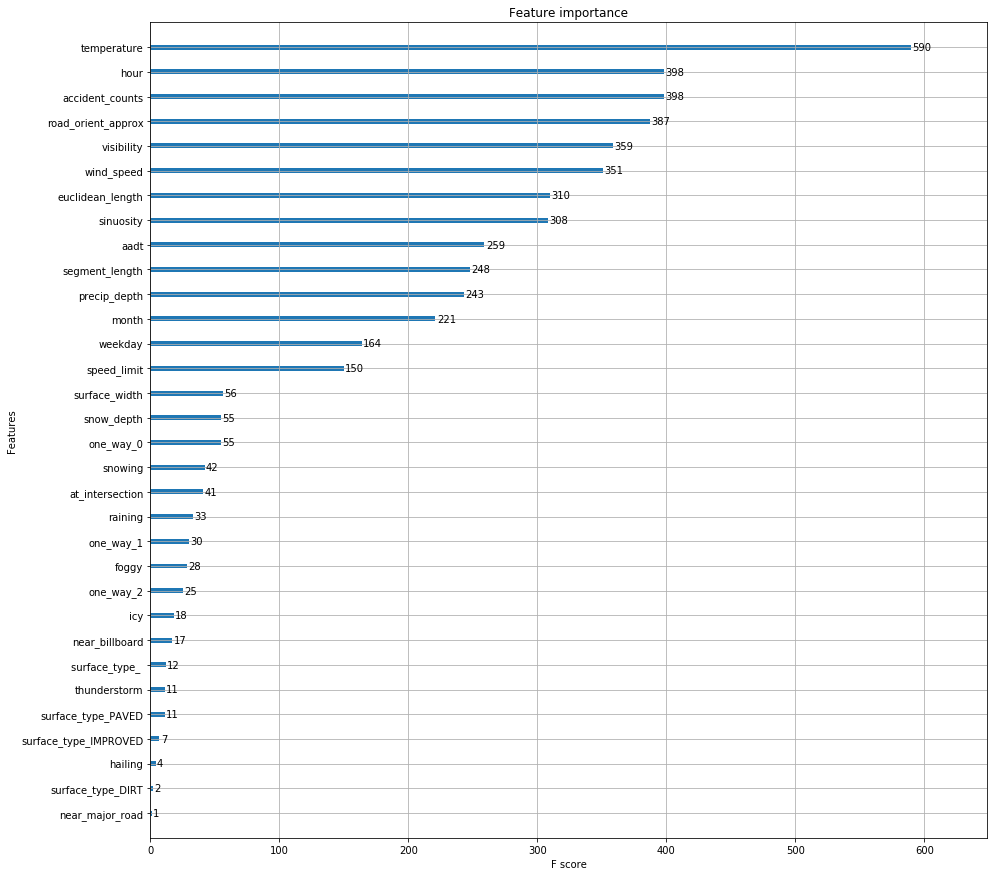

In [12]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='weight')

In [54]:
booster.save_model('0002.model')

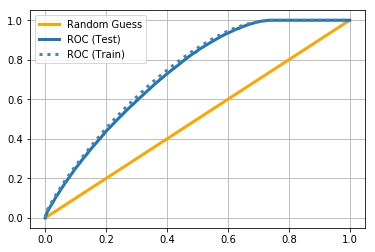

In [13]:
y_pred_test = booster.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)

y_pred_train = booster.predict(X_train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.grid()
plt.legend()

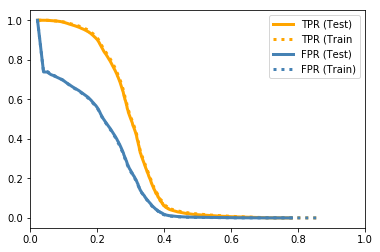

In [14]:

plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,fpr_train,'r:',label='FPR (Train)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.legend()

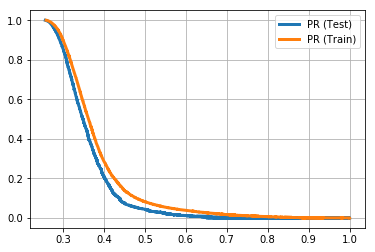

In [15]:
plt.figure(figsize=(15,15))

y_pred_test = booster.predict(X_test)
y_pred_train = booster.predict(X_train)

precision,recall,thresholds = precision_recall_curve(y_test,y_pred_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot(precision,recall,label='PR (Test)',lw=3)
plt.plot(precision_train,recall_train,label='PR (Train)',lw=3)

plt.grid()
plt.legend()

In [16]:
len(X_train.feature_names)

36

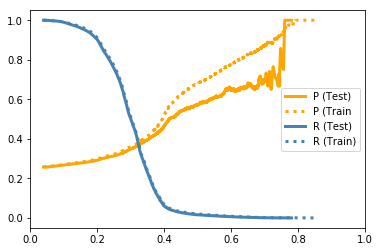

In [17]:
plt.plot(thresholds,precision[:-1],'r-',label='P (Test)',color='orange',lw=3)
plt.plot(thresholds_train,precision_train[:-1],'r:',label='P (Train',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='R (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,recall_train[:-1],'r:',label='R (Train)',color='steelblue',lw=3)
#plt.plot([0,1],[0,1],'k-',lw=2)
plt.gca().set_xbound(lower=0,upper=1)
plt.legend()

In [18]:
y_pred_test = booster.predict(X_test) > 0.2
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test AP:',average_precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(X_test)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))

y_pred_train = booster.predict(X_train) > 0.2
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Test AP:',average_precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(X_train)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))

Test Accuracy: 0.533891039332
Test F1: 0.441036186212
Test Precision: 0.29171461913
Test AP: 0.283206552215
Test Recall: 0.903532168407
Test AUC: 0.731162843825
Train Accuracy: 0.5393202882
Train F1: 0.448944942839
Train Precision: 0.297647796167
Test AP: 0.289639044327
Train Recall: 0.913063749959
Train AUC: 0.7411748026
